# General equations 
$$
        \begin{align*}
            \frac{\partial {\bf u}}{\partial t} + \nabla \cdot \Gamma = f
        \end{align*} \\
        \begin{align*}
            {\bf u} &= \begin{bmatrix}
                p \\
                m \\
                c_f \\
                c_b
            \end{bmatrix}, \,
            \nabla = \frac{\partial}{\partial x}
        \end{align*} \\
        \begin{align*}
            \Gamma &= \begin{bmatrix}
                        0 & -D_m (1-\beta p) \partial_x m & -D_c \partial_x c_f & 0 
                    \end{bmatrix}^T \\
            f &= \begin{bmatrix}
                v \partial_x p - \alpha p c_b \\
                \alpha p c_b \\
                -k_s c_f p + \alpha p c_b \\
                v \partial_x c_b + k_s c_f p - \alpha p c_b
            \end{bmatrix} \\
        \end{align*} \\
        \begin{align*}
            v &= \left. a_{br} k_{br} m^2 p \right\vert_{x=0}  + \left. a_{gr}k_{gr} m p \right\vert_{x=0}
        \end{align*}
$$

With the boundaries both at $x=0$ and $x=L$:
$$
    \begin{align}
        &p = 0 \\
        &D_m (1-\beta p) \partial_x m =  0 \\
        &\frac{\partial c_f}{\partial x} = 0 \\
        &c_b = 0 
    \end{align}
$$


# Discretization
**Convention**: A subscript of $i$ indicates the spatial discretizetion, an upperscript of $n$ indicates the temporal discretization. A subscript with no upper script means the current timestamp ($n$).

### Equations

$$
\begin {align}
    p_i^{n+1} &= p_i + \frac{\Delta t}{2 \Delta x} \cdot v (p_{i+1} -p_{i-1}) - Depoly \\
    m_i^{n+1} &= m_i + D_m \frac{\Delta t}{2 \Delta x^2} \big[(2 - \beta (p_i + p_{i+1}))(m_{i+1}-m_i) - (2 - \beta (p_i + p_{i-1}))(m_{i}-m_{i-1}) \big] + Depoly \\
    c_{f,i}^{n+1} &= c_{f, i} + D_c \frac{\Delta  t}{\Delta x^2} (c_{f, i+1} + c_{f, i-1} - 2 c_{f, i}) - Bind + Depoly \\
    c_{b,i}^{n+1} &= c_{b, i} + v \frac{\Delta  t}{2 \Delta x} (c_{b, i+1} - c_{b, i-1}) + Bind - Depoly
\end{align}
$$

Where:
$$
\begin{align}
    Depoly &= \Delta t \, \alpha c_{b, i} p_i \\ 
    Bind &= \Delta t \, k_s c_{f, i} p_i \\ 
\end{align}
$$

### Boundaries
#### Right boundary
$$
    p_{M} = 0 \\
    m_{M} = m_{M-2} \\
    c_{f, M} = c_{f, M-2} \\
    c_{b, M} = 0 \\
$$

#### Left boundary
$$
\begin{align}
    p_{0} = 0 \\
    m_{0} = m_{2} \\
    c_{f, 0} = c_{f, 2} \\
    c_{b, 0} = 0 \\
\end{align}
$$

* Note that the boundary of $m$ in both cases is dependent on $(1-\beta p)$. If $(1-\beta p) \rightarrow 0$, then $\partial_x m \rightarrow \infty$ 

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# Constants

Dm = 8.4
Dc = 10
beta = 0.1
alpha = 0.5
k_s = 0.01
k_gr = 8.7
k_br = 2.16E-5
a_gr = 2
a_br = 2
m_c = 0.2
l = 0.003



$$
    \begin{align*}
        depoly &= \Delta t \cdot \alpha c_{b,i} p_i \\
        bind &= \Delta t \cdot k_s c_{f,i} p_i
    \end{align*}

$$

$$
    \begin{align*}
        f = \begin{bmatrix}
            v_i \partial_x p - \alpha p c_b \\
            \alpha p c_b \\
            -k_s c_f p + \alpha p c_b \\
            v \partial_x c_b + k_s c_f p - \alpha p c_b
        \end{bmatrix} \\
    \end{align*} \\

$$

In [9]:
def get_f(p, cf, cb, dt, dx, v, alpha):
    """ Calculates the f part of the discretizied equations

    Args:
        p (_type_): p
        cf (_type_): cf
        cb (function): cb
        dt (_type_): dt
        dx (_type_): dx
        v (_type_): v

    Returns:
        tuple: f_p[-1:1], f_m[-1:1], f_cf[-1:1], f_cb[-1:1]
    """
    global k_s

    depoly = (dt*alpha[1: -1])*cb[1:-1]*p[1:-1]
    bind = (dt*k_s)*cf[1:-1]*p[1:-1]


    f_p = v*dt/(2*dx) * (p[2:] - p[:-2]) - depoly
    f_m = depoly
    f_cf = depoly - bind
    f_cb = v*dt/(2*dx) * (cb[2:] - cb[:-2]) - f_cf
    
    return f_p, f_m, f_cf, f_cb


# get_f(np.random.random(100), np.random.random(100), np.random.random(100), 0.01, 0.1, 5)

In [10]:
def solver(I, L, T, dx, dt, user_action=None, stability_safety_factor=1.0, alpha_func=0.5):
    """_summary_
get_f - A function that returns a list of 4 values according to ${\bf f}$. The spatial derivatives would be calculated based on regular finite difference, e.g. $\frac{r_p^{n, m+1} - r_p^{n, m}}{\Delta x}$
    Args:
        I (List[Callable]): Initial condition for all of the dependent variables (list of 4 callables) 
        L (float): Length of domain
        T (float):  Stop time for the simulation 
        dx (float): Space grid unit
        dt (float): Time unit
        user_action (Callable, optional): _description_. Defaults to None.
        stability_safety_factor (float, optional): _description_. Defaults to 1.0.

    Returns:
        _type_: _description_
    """

    global a_br, k_br, a_gr, k_gr, Dm, Dc, beta, l, m_c

    Nt = int(round(T/dt))
    t = np.linspace(0, Nt*dt, Nt+1)      # Mesh points in time

    # Find max(c) using a fake mesh and adapt dx to C and dt
    # c_max = max([c(x_) for x_ in np.linspace(0, L, 101)])
    # dx = dt*c_max/(stability_safety_factor*C)

    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)          # Mesh points in space

    p = np.vectorize(I[0], otypes=[float])(x)
    m = np.vectorize(I[1], otypes=[float])(x)
    cf = np.vectorize(I[2], otypes=[float])(x)
    cb = np.vectorize(I[3], otypes=[float])(x)
    
    alpha = np.vectorize(alpha_func)(x)


    for n in t:
        v = (a_br*k_br*(m[1]**2) + a_gr*k_gr*(m[1]-m_c)) * p[1]

        if user_action:
            user_action(p=p, m=m, cf=cf, cb=cb, v=v, dx=dx, dt=dt, x=x, t=t, n=n)

        
        f = get_f(p, cf, cb, dt, dx, v, alpha)
        # Calculate boundaries
        p_L, m_L, cf_L, cb_L = 0, m[-3], cf[-3], 0
        p_0, m_0, cf_0, cb_0 = 0, m[2], cf[2], 0

        # Calculate inner-points
        m_flux = Dm*dt/(2*dx**2) * \
                    ((2-beta*(p[1: -1] + p[2:]))*(m[2:] - m[1: -1]) - (2-beta*(p[1: -1] + p[:-2]))*(m[1: -1] - m[:-2]))
        # print(m_flux)
        p[1: -1] = p[1: -1] + f[0]
        # print(f[1])
        m[1: -1] = m[1: -1] +  m_flux + f[1]
        # print(m[1: -1])
        cf[1: -1] = cf[1: -1] + Dc*dt/(dx**2) * (cf[2:] + cf[:-2] - 2*cf[1:-1]) + f[2]
        cb[1: -1] = cb[1: -1] + f[3]

        # Set boundaries

        p[-1], m[-1], cf[-1], cb[-1] = p_L, m_L, cf_L, cb_L
        p[0], m[0], cf[0], cb[0] = p_0, m_0, cf_0, cb_0

    return p, m, cf, cb, x, t


In [12]:
import math
from IPython import display
from time import sleep

I = [
    lambda p: 0.1 * (p < 0.1),
    lambda m: 0,
    lambda cf: 0,
    lambda cb: 0.2 * (cb < 0.5),
]

# fig = plt.figure()
v = np.array(0)
def append_v(**kwargs):
    global v
    v_timestamp = kwargs['v']
    v = np.append(v, v_timestamp)

def plot(**kwargs):
    n = kwargs['n']
    if not( n % 0.01 <= 1e-6):
        return
        
    x = kwargs['x']
    m = kwargs['cb']
    plt.title(f"t={n}")
    plt.plot(x, m, '-r')
    plt.ylim((-0.1, 1))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    sleep(0.1)
    plt.clf()

def log_numbers(**kwargs):
    parameters = ["p", "m", "cf", "cb", "n"]
    [print(f"{k}: {kwargs[k]}, ", end="") for k in parameters]
    print()

def aggregate_gen(arr):
    def aggregate(**kwargs):
        for k in arr:
            _sum = sum(kwargs[k])
            print(f"{k}: {_sum}")
            


    return aggregate

monomers = []

def monomer_sum(**kwargs):
    global L, monomers

    x = kwargs["x"]
    p = kwargs["p"]
    m = kwargs["m"]

    sum_p = sum(p)/len(x)
    sum_m = sum(m)/len(x)
    # print(f"Monomers: {sum_m + sum_p}")
    monomers.append(sum_m + sum_p)
    return 

    
sol = solver(I, 1, 2, 0.01, 1e-6, user_action=monomer_sum, alpha_func=lambda y: 1)


KeyboardInterrupt: 

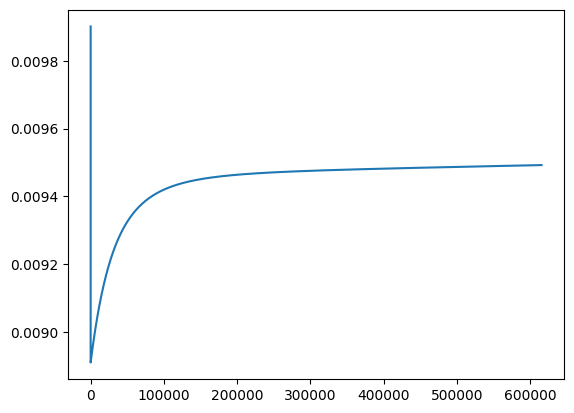

In [18]:
plt.plot(monomers)